# Summary of Results

## Load Model Training Results

In [7]:
import pandas as pd

# load the classifier results
classifier_results = pd.read_json('data/classifiers_perf_result.json')
classifier_results

,classifier,best_params,train_time,accuracy_train,accuracy_test,conf_matrix
0,MultinomialNB,{'alpha': 6.43682507},8.496745,0.473885,0.473339,"[[0.5072463768000001, 0.0, 0.00671556980000000..."
1,RandomForestClassifier,"{'max_depth': 8, 'min_samples_leaf': 3, 'min_s...",2511.756775,0.586964,0.537629,"[[0.0, 0.0, 0.0020100503, 0.1012507445, 0.0, 0..."
2,XGBClassifier,"{'gamma': 9.3328014016, 'learning_rate': 0.326...",30.916079,0.602910,0.530926,"[[0.5681818182, 0.0, 0.0020378806, 0.067285908..."


In [8]:
# load the neural net classifiers
nn_results = pd.read_json('data/nn_perf_result.json')
nn_results

,train time,accuracy_train,accuracy_test,conf_matrix
0,5.155043,0.525340,0.521328,"[[0.8125, 0.07708553330000001, 0.0061840121000..."
1,17.817954,0.587066,0.584197,"[[0.48037383180000004, 0.0304248995, 0.0007704..."
2,25.689402,0.570384,0.566067,"[[0.6271186441000001, 0.10443431410000001, 0.0..."


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# the target classes
ratings = ['acceptable', 'good', 'very good', 'excellent', 'superb', 'classic']

def plot_confusion_matrix(conf_matrix, title):
  fig = plt.figure(figsize=(6, 3))
  ax = sns.heatmap(conf_matrix, xticklabels=ratings, yticklabels=ratings, annot=True, cmap="Purples", fmt=",.2f", annot_kws={"size": 8}, )
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=9, rotation=45)
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=9)
  ax.set_ylabel('True Labels', fontdict={'size': 10})
  ax.set_xlabel('Predictions', fontdict={'size': 10})
  cbar = ax.collections[0].colorbar
  cbar.ax.tick_params(labelsize=9)
  plt.title(title)
  plt.tight_layout()
  plt.show()

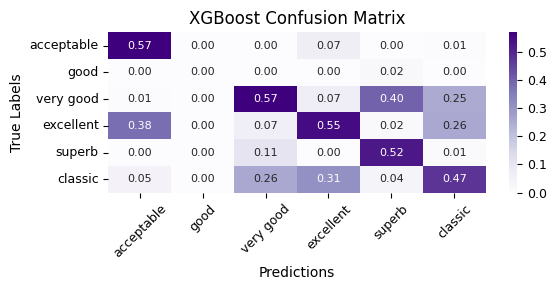

In [10]:
plot_confusion_matrix(classifier_results.loc[2, 'conf_matrix'], 'XGBoost Confusion Matrix')

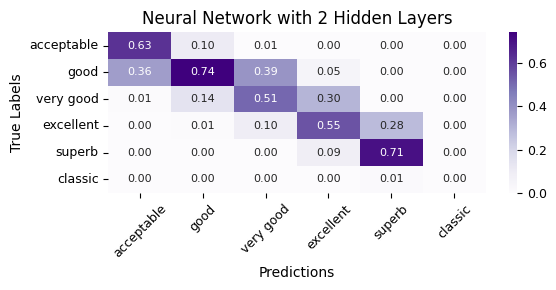

In [11]:
plot_confusion_matrix(nn_results.loc[2, 'conf_matrix'], 'Neural Network with 2 Hidden Layers')

## Conclusion

Based on the confusion matrix, the neural classifier appears to have done a better job of predicting the rating based on the review than the XGBoost classifier. Not only did it achieve an accuracy of $61.6\%$, but the mislabels mostly were along the diagonal, indicating it was in the right direction. In contrast, XGBoost misclassified reviews far off the diagonal, indicating it was confusing reviews for wines that were rated very differently.
